## Part 2: Vice Presidential and Presidential Debate Analysis
* Debates are a tool for the candidates to appeal to an audience deciding who to vote for in the election. 
    * Viewers of these debates might already have a candidate in mind, but the audience isn't directed towards only one side, like the conventions. 
* This analysis will include a classifier, which will try to predict if a spoken line is republican or democratic.
    * Goal: find key words used by each candidate to further their arguments. Also, find accuracy of the classifier for my hypothesis. 
* I will also be making a model based off of token length to see if speaking a lot is a persuasion choice made by the candidates. 

In [1]:
import pandas as pd
import numpy as np
import nltk
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns        # seaborn graphical package
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

In [2]:
presdebate = pd.read_csv("/Users/emmatarcson/Documents/data_science/RhetoricalFactor-analysis/data/only_D_and_R/welkerPRESdebate.csv")
presdebate = presdebate[['Aff','transcript']]
presdebate.Aff.value_counts()

R    193
D    131
Name: Aff, dtype: int64

In [15]:
import re
trans_toks = [nltk.word_tokenize(re.sub(r'[^\w+ ]', '', t.lower())) for t in presdebate['transcript']]
trans_tok_lens = [len(t) for t in trans_toks]
sents = [len(nltk.sent_tokenize(t)) for t in presdebate['transcript']]
presdebate['Token_Len'] = trans_tok_lens
presdebate['SentAmt'] = sents
presdebate['AVGSENTLEN'] = presdebate.Token_Len/presdebate.SentAmt

In [4]:
presdebate

,Aff,transcript,Token_Len
0,R,How are you doing? How are you?,7
1,R,"So as you know, 2.2 million people modeled out...",101
2,R,There was a very big spike in Texas. It’s now ...,73
3,R,"I can tell you from personal experience, I was...",191
4,D,"220,000 Americans dead. You hear nothing else ...",102
...,...,...,...
319,R,"Before the plague came in, just before, I was ...",76
320,R,Success is going to bring us together. We are ...,71
321,D,"I will say, I’m an American President. I repre...",71
322,D,"We can grow this economy, we can deal with the...",103


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
X = presdebate[['Token_Len', 'AVGSENTLEN', 'SentAmt']]
y = presdebate['Aff']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=0)


lr_model = LogisticRegression()   # default setting
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.5846153846153846

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(presdebate['transcript'], presdebate['Aff'], random_state=0,
                                  train_size=0.6)
vectorizer = TfidfVectorizer(min_df=1, max_features=4000, tokenizer=nltk.word_tokenize)

X_text_train = vectorizer.fit_transform(X_train)
X_text_test = vectorizer.transform(X_test)

from sklearn.svm import SVC 
svcmodel = SVC(kernel='linear', C=1E5)  
svcmodel.fit(X_text_train, y_train)

SVC(C=100000.0, kernel='linear')

In [5]:
pred = svcmodel.predict(X_text_test)
print(y_test[:20])
print(pred[:20])

295    R
65     R
15     D
274    D
140    D
153    D
101    D
234    R
63     D
159    R
184    D
181    R
97     D
219    D
215    D
64     R
26     R
256    R
92     R
108    R
Name: Aff, dtype: object
['R' 'R' 'D' 'R' 'D' 'D' 'D' 'R' 'R' 'R' 'D' 'R' 'D' 'D' 'R' 'R' 'R' 'R'
 'D' 'R']


In [6]:
accuracy_score(y_test, pred) #wow, not that good with a debate. these are just with sentences. 

0.6615384615384615

In [7]:
letssee = [x for x in pred if x == 'R']
len(letssee) #how many times it predicted R

79

/Users/emmatarcson/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=['D', 'R'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


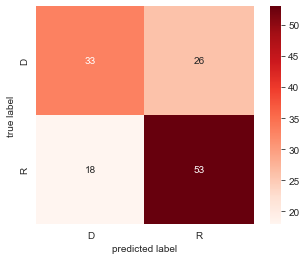

In [8]:
from sklearn.metrics import confusion_matrix
labels = ['D','R']
mat = confusion_matrix(y_test, pred, labels)
sns.heatmap(mat, square=True, annot=True, fmt='d', cmap="Reds",
           xticklabels=labels, yticklabels=labels)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

Looks like it guessed 'R' wrongly a lot. 

In [9]:
# Now let's do it with cleaner data

just_R = presdebate[presdebate.Aff == 'R']
just_R = just_R[:131]
just_D = presdebate[presdebate.Aff == 'D']
presdebate2 = pd.concat([just_R, just_D])
presdebate2.Aff.value_counts()

R    131
D    131
Name: Aff, dtype: int64

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(presdebate2['transcript'], presdebate2['Aff'], random_state=0,
                                  train_size=0.6)
vectorizer = TfidfVectorizer(min_df=1, max_features=4000, tokenizer=nltk.word_tokenize)

X_text_train = vectorizer.fit_transform(X_train)
X_text_test = vectorizer.transform(X_test)

from sklearn.svm import SVC 
svcmodel = SVC(kernel='linear', C=1E5)  
svcmodel.fit(X_text_train, y_train)
pred = svcmodel.predict(X_text_test)
accuracy_score(y_test, pred) #worked a little better but nothing satisying. 

0.6857142857142857

In [240]:
# the coefficent flattens with binary classes, so I'm still currently looking for a way to find the most informative
# features :/

# otherwise, I will need to use the csv file with the all three speakers

In [3]:
allpresdebate = pd.read_csv("/Users/emmatarcson/Documents/data_science/RhetoricalFactor-analysis/data/all_speakers/presdebatewelker.csv")
allpresdebate = allpresdebate[['Aff','transcript']]
allpresdebate.Aff.value_counts()

R       193
None    188
D       131
Name: Aff, dtype: int64

In [12]:
# evening them out, otherwise it was barely guessing 'D'
just_R = allpresdebate[allpresdebate.Aff == 'R']
just_R = just_R[:131]
just_none = allpresdebate[allpresdebate.Aff == 'None']
just_none = just_none[:131]
just_D = allpresdebate[allpresdebate.Aff == 'D']
allpresdebate2 = pd.concat([just_R, just_D, just_none])
allpresdebate2.Aff.value_counts()
shuf_data = allpresdebate2.sample(frac=1, random_state=1)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(shuf_data['transcript'], shuf_data['Aff'], random_state=0,
                                  train_size=0.6)
nbmodel = MultinomialNB()
vectorizer = TfidfVectorizer(max_df=0.5, min_df=2,max_features=1500, stop_words='english') #using this to find vocab
X_text_train = vectorizer.fit_transform(X_train)
X_text_test = vectorizer.transform(X_test)


nbmodel.fit(X_text_train, y_train)
pred = nbmodel.predict(X_text_test)
accuracy_score(y_test, pred) 
#the accuracy actually got better... maybe this is because features become more polarized when there is neutral weight?

0.7784810126582279

In [14]:
nbmodel.coef_ #nice! we actually have separated coefficent lists this time

array([[-5.55251847, -5.75933542, -6.57989899, ..., -6.47886584,
        -6.44956437, -6.12571365],
       [-5.91108231, -6.18081174, -6.17628992, ..., -6.54489505,
        -6.27528041, -6.36434925],
       [-5.41725611, -6.27436623, -6.3043343 , ..., -5.92007281,
        -6.23543389, -6.5677607 ]])

In [15]:
letssee = [x for x in pred if x == 'D']
len(letssee) #how many times it predicted R, this just makes sure the confusion matrix has the right labels

42

/Users/emmatarcson/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=['D', 'R', 'None'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


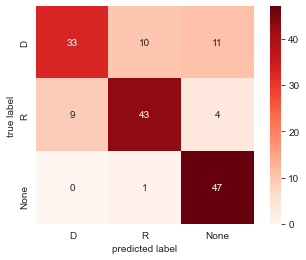

In [16]:
# it never predicted as m
from sklearn.metrics import confusion_matrix
labels = ['D','R','None']
mat = confusion_matrix(y_test, pred, labels)
sns.heatmap(mat, square=True, annot=True, fmt='d', cmap="Reds",
           xticklabels=labels, yticklabels=labels)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show() 

In [17]:
def print_top(vectorizer, clf, class_labels, n):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        top = np.argsort(clf.coef_[i])[0-n:]
        print("%s: %s" % (class_label,
              ", ".join(feature_names[j].replace(' ', '-') for j in top)))
    

print_top(vectorizer, nbmodel, nbmodel.classes_, 40)

D: lot, years, clear, plan, guy, healthcare, industry, 000, united, crosstalk, money, american, know, oil, transition, come, republican, didn, things, wrong, deal, look, don, stop, states, president, 00, talking, fracking, fact, make, people, did, sure, china, way, respond, said, true, going
None: hill, capitol, haven, american, ve, section, tell, need, new, ask, immigration, questions, reaction, 10, uninterrupted, 30, korea, recently, gentlemen, north, minutes, families, mr, follow, respond, want, said, seconds, right, talk, question, going, quickly, okay, response, biden, vice, let, trump, president
R: politician, soon, kristen, places, big, 28, country, built, different, gave, million, doesn, did, cages, ago, typical, respond, know, got, crosstalk, ve, didn, years, china, thing, said, work, like, going, just, people, 00, doing, say, joe, money, come, think, excuse, don


* joe, joe, joe.. fracking...
* D: 'fact'? -> people at home watching the debate and hear 'fact'... 
* it does seem like they are using some rhetorically weighted words like 'healthcare', 'united', 'immigration'
* with debates, I expect like super heavy words that pull people's attention and whatnot
* honestly, looking at this, I feel like I could predict correctly which is which
    * that being said, though, the classifier was a little worse that the speeches, which says to me that debates use speech that will attract both sides? Or maybe since they both had to answer questions about specific topics, which makes it interesting that there was still a bit of weight tied to certain topic words. 

In [31]:
# I'm gonna add more features

presdebate.transcript[1]

'So as you know, 2.2 million people modeled out, were expected to die. We closed up the greatest economy in the world in order to fight this horrible disease that came from China. It’s a worldwide pandemic. It’s all over the world. You see the spikes in Europe and many other places right now. If you notice, the mortality rate is down 85%. The excess mortality rate is way down and much lower than almost any other country. And we’re fighting it and we’re fighting it hard. There is a spike. There was a spike in Florida and it’s now gone.'

In [300]:
import re
trans_toks = [nltk.word_tokenize(re.sub(r'[^\w+ ]', '', t.lower())) for t in presdebate['transcript']]
trans_tok_lens = [len(t) for t in trans_toks]
type_len = [len(set(t)) for t in trans_toks]
TTR = [len(set(t))/len(t) for t in trans_toks]

presdebate['Toks'] = trans_toks
presdebate['Token_count'] = trans_tok_lens
presdebate['Type_count'] = type_len
presdebate['TTR'] = TTR # might have to get rid of words that only have a couple words

In [301]:
presdebate 

,Aff,transcript,Toks,Token_count,Type_count,TTR
0,R,How are you doing? How are you?,"[how, are, you, doing, how, are, you]",7,4,0.571429
1,R,"So as you know, 2.2 million people modeled out...","[so, as, you, know, 22, million, people, model...",101,68,0.673267
2,R,There was a very big spike in Texas. It’s now ...,"[there, was, a, very, big, spike, in, texas, i...",73,42,0.575342
3,R,"I can tell you from personal experience, I was...","[i, can, tell, you, from, personal, experience...",191,106,0.554974
4,D,"220,000 Americans dead. You hear nothing else ...","[220000, americans, dead, you, hear, nothing, ...",102,70,0.686275
...,...,...,...,...,...,...
319,R,"Before the plague came in, just before, I was ...","[before, the, plague, came, in, just, before, ...",76,53,0.697368
320,R,Success is going to bring us together. We are ...,"[success, is, going, to, bring, us, together, ...",71,53,0.746479
321,D,"I will say, I’m an American President. I repre...","[i, will, say, im, an, american, president, i,...",71,42,0.591549
322,D,"We can grow this economy, we can deal with the...","[we, can, grow, this, economy, we, can, deal, ...",103,70,0.679612


In [4]:
vpdebate = pd.read_csv("/Users/emmatarcson/Documents/data_science/RhetoricalFactor-analysis/data/only_D_and_R/pageVPdebate.csv")
vpdebate = vpdebate[['Aff','transcript']]
vpdebate.Aff.value_counts()

R    113
D     94
Name: Aff, dtype: int64

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(vpdebate['transcript'], vpdebate['Aff'], random_state=0,
                                  train_size=0.6)
vectorizer = TfidfVectorizer(min_df=1, max_features=4000, tokenizer=nltk.word_tokenize)

X_text_train = vectorizer.fit_transform(X_train)
X_text_test = vectorizer.transform(X_test)

from sklearn.svm import SVC 
svcmodel = SVC(kernel='linear', C=1E5)  
svcmodel.fit(X_text_train, y_train)
pred = svcmodel.predict(X_text_test)
accuracy_score(y_test, pred)

0.7831325301204819

In [5]:
allvpdebate = pd.read_csv("/Users/emmatarcson/Documents/data_science/RhetoricalFactor-analysis/data/all_speakers/pagedebate2020.csv")
allvpdebate = allvpdebate[['Aff','transcript']]
allvpdebate.Aff.value_counts()

None    120
R       113
D        94
Name: Aff, dtype: int64

In [21]:
just_R = allvpdebate[allvpdebate.Aff == 'R']
just_R = just_R[:94]
just_none = allvpdebate[allvpdebate.Aff == 'None']
just_none = just_none[:94]
just_D = allvpdebate[allvpdebate.Aff == 'D']
allvpdebate2 = pd.concat([just_R, just_D, just_none])
allvpdebate2.Aff.value_counts()
shuf_data = allvpdebate2.sample(frac=1, random_state=1)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(shuf_data['transcript'], shuf_data['Aff'], random_state=0,
                                  train_size=0.6)
nbmodel = MultinomialNB()
vectorizer = TfidfVectorizer(max_df=0.5, min_df=2,max_features=1500, stop_words='english') #using this to find vocab
X_text_train = vectorizer.fit_transform(X_train)
X_text_test = vectorizer.transform(X_test)


nbmodel.fit(X_text_train, y_train)
pred = nbmodel.predict(X_text_test)
accuracy_score(y_test, pred) 

0.7345132743362832

In [23]:
def print_top(vectorizer, clf, class_labels, n):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        top = np.argsort(clf.coef_[i])[0-n:]
        print("%s: %s" % (class_label,
              ", ".join(feature_names[j].replace(' ', '-') for j in top)))
    

print_top(vectorizer, nbmodel, nbmodel.classes_, 40)

D: future, record, calm, justice, respond, country, criminal, united, time, great, doesn, need, 000, states, packing, mr, vice, administration, based, like, stage, means, talk, fact, leadership, jobs, american, trump, president, donald, issue, know, america, said, thank, biden, speaking, people, let, joe
None: tonight, right, good, presidential, question, make, voters, time, segue, court, covid, trump, information, course, china, death, think, need, uninterrupted, trying, important, ve, administration, talk, 15, seconds, americans, minutes, issue, topic, respond, yes, chance, want, harris, senator, president, pence, vice, thank
R: china, jobs, pandemic, economy, really, reality, regard, year, just, like, question, know, answer, coronavirus, states, continue, united, believe, said, court, look, supreme, america, did, green, million, joe, deal, biden, years, new, donald, senator, going, people, ve, trump, president, susan, american


In [314]:
import re
trans_toks = [nltk.word_tokenize(re.sub(r'[^\w+ ]', '', t.lower())) for t in vpdebate['transcript']]
trans_tok_lens = [len(t) for t in trans_toks]
type_len = [len(set(t)) for t in trans_toks]
TTR = [len(set(t))/len(t) for t in trans_toks]

vpdebate['Toks'] = trans_toks
vpdebate['Token_count'] = trans_tok_lens
vpdebate['Type_count'] = type_len
vpdebate['TTR'] = TTR # might have to get rid of words that only have a couple words

In [315]:
vpdebate

,Aff,transcript,Toks,Token_count,Type_count,TTR
0,D,"Thank you, Susan. Well, the American people ha...","[thank, you, susan, well, the, american, peopl...",146,87,0.595890
1,D,"Can you imagine if you knew on January 28th, a...","[can, you, imagine, if, you, knew, on, january...",177,87,0.491525
2,D,… right to reelection based on this.,"[right, to, reelection, based, on, this]",6,6,1.000000
3,R,"Susan, thank you. And I want to thank the Comm...","[susan, thank, you, and, i, want, to, thank, t...",163,108,0.662577
4,R,And I believe it saved hundreds of thousands o...,"[and, i, believe, it, saved, hundreds, of, tho...",198,118,0.595960
...,...,...,...,...,...,...
202,R,I look at the relationship between Justice Rut...,"[i, look, at, the, relationship, between, just...",185,110,0.594595
203,D,"First of all, I love hearing from our young le...","[first, of, all, i, love, hearing, from, our, ...",57,37,0.649123
204,D,"And brings me to Joe, Joe Biden. One of the re...","[and, brings, me, to, joe, joe, biden, one, of...",73,50,0.684932
205,D,Joe has a longstanding reputation of working a...,"[joe, has, a, longstanding, reputation, of, wo...",61,42,0.688525


In [40]:
alldebates = pd.concat([vpdebate, presdebate])
alldebates.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 531 entries, 0 to 323
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Aff         531 non-null    object
 1   transcript  531 non-null    object
dtypes: object(2)
memory usage: 12.4+ KB


In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(alldebates['transcript'], alldebates['Aff'], random_state=0,
                                  train_size=0.6)
vectorizer = TfidfVectorizer(max_df = .5, min_df=1, max_features=2000, tokenizer = nltk.word_tokenize)

X_text_train = vectorizer.fit_transform(X_train)
X_text_test = vectorizer.transform(X_test)

from sklearn.svm import SVC 
svcmodel = SVC(kernel='linear', C=1)  
svcmodel.fit(X_text_train, y_train)

SVC(C=1, kernel='linear')

In [42]:
pred = svcmodel.predict(X_text_test)
accuracy_score(y_test, pred)

0.7699530516431925

/Users/emmatarcson/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=['D', 'R'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


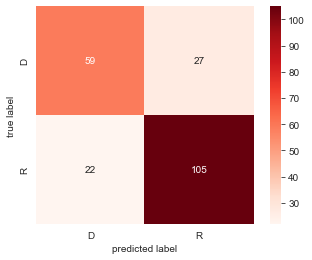

In [44]:
from sklearn.metrics import confusion_matrix
labels = ['D','R']
mat = confusion_matrix(y_test, pred, labels)
sns.heatmap(mat, square=True, annot=True, fmt='d', cmap="Reds",
           xticklabels=labels, yticklabels=labels)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show() 

In [46]:
alldebates = pd.concat([allvpdebate, allpresdebate])
alldebates.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 839 entries, 0 to 511
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Aff         839 non-null    object
 1   transcript  839 non-null    object
dtypes: object(2)
memory usage: 19.7+ KB


In [26]:
X_train, X_test, y_train, y_test = train_test_split(alldebates['transcript'], alldebates['Aff'], random_state=0,
                                  train_size=0.6)
nbmodel = MultinomialNB()
vectorizer = TfidfVectorizer(ngram_range = (2,2), max_df=0.5, min_df=2,max_features=1500, stop_words='english') #using this to find vocab
X_text_train = vectorizer.fit_transform(X_train)
X_text_test = vectorizer.transform(X_test)


nbmodel.fit(X_text_train, y_train)
pred = nbmodel.predict(X_text_test)
accuracy_score(y_test, pred) 
def print_top(vectorizer, clf, class_labels, n):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        top = np.argsort(clf.coef_[i])[0-n:]
        print("%s: %s" % (class_label,
              ", ".join(feature_names[j].replace(' ', '-') for j in top)))
    

print_top(vectorizer, nbmodel, nbmodel.classes_, 40)

D: red-states, problem-going, rudy-giuliani, net-zero, commander-chief, live-near, asking-people, learn-going, don-think, don-worry, going-going, 000-year, president-obama, know-joe, abraham-lincoln, make-china, need-help, people-country, god-going, business-china, know-know, 00-01, important-want, public-option, zero-emissions, 00-34, vice-president, future-bright, states-america, making-sure, 38-000, oil-industry, president-united, let-talk, make-sure, american-people, donald-trump, crosstalk-00, united-states, joe-biden
None: pence-time, follow-vice, president-question, pence-senator, going-section, say-americans, minimum-wage, right-gentlemen, want-talk, ask-vice, lot-questions, good-evening, pence-thank, let-section, trump-reaction, okay-vice, biden-response, let-talk, mr-president, okay-let, let-vice, let-follow, final-question, biden-let, 10-seconds, north-korea, chance-respond, mr-vice, climate-change, right-let, crosstalk-00, minutes-uninterrupted, let-ask, thank-senator, sena

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC 
from sklearn.model_selection import GridSearchCV

x = alldebates.transcript[:1000] #making it smaller cause I'm scared of CRC
y = alldebates.Aff[:1000]

tfidf_model = TfidfVectorizer()
svc_model = SVC()

# create a pipeline with step names
pipe = Pipeline(steps=[('tfidf', tfidf_model), ('svc', svc_model)])

param_grid = {
    'tfidf__max_features': [2000, 3000],        
    'tfidf__stop_words': ['english', None],
    'tfidf__max_df': [.5],
    'svc__C': [1],
    'svc__kernel' : ['linear'],
    'svc__gamma' : [1]
}                            # 8 parameter combos

search = GridSearchCV(pipe, param_grid, n_jobs=3, cv=5)  # 8x5 = 40 models
search.fit(x, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('svc', SVC())]),
             n_jobs=3,
             param_grid={'svc__C': [1], 'svc__gamma': [1],
                         'svc__kernel': ['linear'], 'tfidf__max_df': [0.5],
                         'tfidf__max_features': [2000, 3000],
                         'tfidf__stop_words': ['english', None]})

In [33]:
print('best parameters:', search.best_params_)     # best-performing parameter combo
print('best mean accuracy:', search.best_score_)

best parameters: {'svc__C': 1, 'svc__gamma': 1, 'svc__kernel': 'linear', 'tfidf__max_df': 0.5, 'tfidf__max_features': 2000, 'tfidf__stop_words': None}
best mean accuracy: 0.722291132021671


In [47]:
X_train, X_test, y_train, y_test = train_test_split(alldebates['transcript'], alldebates['Aff'], random_state=0,
                                  train_size=0.6)
nbmodel = MultinomialNB()
vectorizer = TfidfVectorizer(max_df=0.5, min_df=2,max_features=1500, stop_words='english') #using this to find vocab
X_text_train = vectorizer.fit_transform(X_train)
X_text_test = vectorizer.transform(X_test)


nbmodel.fit(X_text_train, y_train)
pred = nbmodel.predict(X_text_test)
accuracy_score(y_test, pred) 
def print_top(vectorizer, clf, class_labels, n):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        top = np.argsort(clf.coef_[i])[0-n:]
        print("%s: %s" % (class_label,
              ", ".join(feature_names[j].replace(' ', '-') for j in top)))
    

print_top(vectorizer, nbmodel, nbmodel.classes_, 40)

D: come, plan, like, trying, got, didn, need, country, don, sure, trump, look, donald, jobs, true, 000, way, let, united, parents, make, saying, thank, america, money, american, biden, crosstalk, states, 00, china, fact, know, president, did, respond, people, going, joe, said
None: korea, north, crosstalk, ve, sorry, final, need, chance, 00, 10, questions, said, issue, uninterrupted, yes, mr, time, talk, want, minutes, seconds, section, ask, follow, respond, quickly, response, going, question, senator, harris, biden, right, trump, okay, let, pence, thank, vice, president
R: tax, crosstalk, work, statement, biggest, country, big, fracking, kristen, want, like, china, come, thing, 00, deal, don, biden, senator, susan, think, got, ll, russia, look, know, say, didn, years, did, said, just, going, ve, trump, people, president, joe, american, excuse
